# Carbon Flux

## Carbon Monitoring Project

[FluxNet](https://fluxnet.fluxdata.org/) is a worldwide collection of sensor stations that record a number of local variables relating to atmospheric conditions, solar flux and soil moisture. This notebook visualizes the data used in the NASA Goddard/University of Alabama carbon monitoring project [NEE Data Fusion](https://www.nas.nasa.gov/SC18/demos/demo33.html) (Grey Nearing et al., 2018), but using Python tools rather than Matlab.

The scientific goals of this notebook are to:

* examine the carbon flux measurements from each site (net C02 ecosystem exchange, or NEE)
* determine the feasibility of using a model to predict the carbon flux at one site from every other site.
* generate and explain model

The "meta" goal is to show how Python tools let you solve the scientific goals, so that you can apply these tools to your own problems.

In [1]:
import numpy as np
import pandas as pd
import hvplot.pandas  # noqa

pd.options.display.max_columns = 10

## Download data

In order to get the full dataset for this notebook, you should run `anaconda-project run pre-build` to get the `.csv` files needed in the later sections of this notebook.

## Load metadata
First we will load in the `fluxnet_metadata` containing some site information for each of the fluxnet sites. Included in these data are the `lat` and `lon` of each site and the vegetation encoding (more on this below). In the next cell we will read in these data and take a look at a random few lines:

In [2]:
path = 'data/allflux_metadata.txt'

metadata = pd.read_csv(
    path,
    header=None,
    names=['site', 'lat', 'lon', 'igbp', 'network'],
    usecols=['site', 'lat', 'lon', 'igbp'],
)

metadata.sample(5)

site      lat       lon igbp
43   US-CaV  39.0633  -79.4208  GRA
201  CZ-wet  49.0247   14.7704  WET
187  CH-Oe1  47.2858    7.7319  GRA
186  CH-Lae  47.4781    8.3650   MF
255  JP-MBF  44.3869  142.3186  DBF

The vegetation type is classified according to the categories set out in the International Geosphere–Biosphere Programme (**igbp**) with several additional categories defined on the [FluxNet website](https://fluxnet.org/data/la-thuile-dataset/).

In [3]:
igbp_vegetation = {
    'WAT': '00 - Water',
    'ENF': '01 - Evergreen Needleleaf Forest',
    'EBF': '02 - Evergreen Broadleaf Forest',
    'DNF': '03 - Deciduous Needleleaf Forest',
    'DBF': '04 - Deciduous Broadleaf Forest',
    'MF' : '05 - Mixed Forest',
    'CSH': '06 - Closed Shrublands',
    'OSH': '07 - Open shrublands',
    'WSA': '08 - Woody Savannas',
    'SAV': '09 - Savannas',
    'GRA': '10 - Grasslands',
    'WET': '11 - Permanent Wetlands',
    'CRO': '12 - Croplands',
    'URB': '13 - Urban and Built-up',
    'CNV': '14 - Cropland/Nartural Vegetation Mosaics',
    'SNO': '15 - Snow and Ice',
    'BSV': '16 - Baren or Sparsely Vegetated'
}

We can use the dictionary above to map from igbp codes to longer labels - creating a new column on our metadata. We will make this column an ordered categorical to improve visualizations.

In [4]:
from pandas.api.types import CategoricalDtype

dtype = CategoricalDtype(ordered=True, categories=sorted(igbp_vegetation.values()))
metadata['vegetation'] = metadata['igbp'].map(igbp_vegetation).astype(dtype)

metadata.sample(5)

site      lat      lon igbp                        vegetation
157  BE-Bra  51.3076   4.5198   MF                 05 - Mixed Forest
159  BE-Vie  50.3050   5.9981   MF                 05 - Mixed Forest
49   US-Dk1  35.9712 -79.0934  GRA                   10 - Grasslands
93   US-Ro5  44.6910 -93.0576  CRO                    12 - Croplands
231  FI-Sod  67.3624  26.6386  ENF  01 - Evergreen Needleleaf Forest

### Visualize the fluxdata sites

The PyViz ecosystem strives to make it always straightforward to visualize your data, to encourage you to be aware of it and understand it at each stage of a workflow. Here we will use Open Street Map tiles from `geoviews` 
to make a quick map of where the different sites are located and the vegetation at each site. 

In [5]:
metadata.hvplot.points('lon', 'lat', geo=True, color='vegetation',
                       height=420, width=800, cmap='Category20', tiles='OSM')

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [lon,lat]   (vegetation)

## Loading FluxNet data

The data in the nee_data_fusion repository is expressed as a collection of CSV files where the site names are expressed in the filenames.

This cell defines a function to:

* read in the data from all sites
* discard columns that we don't need
* calculate day of year
* caculate the season (spring, summer, fall, winter)

In [6]:
data_columns = ['P_ERA', 'TA_ERA', 'PA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'WS_ERA',
                'VPD_ERA', 'TIMESTAMP', 'site', 'NEE_CUT_USTAR50']
soil_data_columns = ['SWC_F_MDS_1', 'SWC_F_MDS_2', 'SWC_F_MDS_3',
                     'TS_F_MDS_1', 'TS_F_MDS_2', 'TS_F_MDS_3']

keep_from_csv = data_columns + soil_data_columns

y_variable = 'NEE_CUT_USTAR50'

def season(df, site, metadata):
    """Add season column based on latitude and month."""
    lat = metadata[metadata['site'] == site]['lat'].item()
    if lat > 0:
        seasons = {3: 'spring', 4: 'spring', 5: 'spring',
                   6: 'summer', 7: 'summer', 8: 'summer',
                   9: 'fall', 10: 'fall', 11: 'fall',
                   12: 'winter', 1: 'winter', 2: 'winter'}
    else:
        seasons = {3: 'fall', 4: 'fall', 5: 'fall',
                   6: 'winter', 7: 'winter', 8: 'winter',
                   9: 'spring', 10: 'spring', 11: 'spring',
                   12: 'summer', 1: 'summer', 2: 'summer'}

    def map_month_to_season(partition):
        partition['season'] = partition['TIMESTAMP'].dt.month.map(seasons)
        return partition

    meta = df._meta.copy()
    meta['season'] = pd.Series(dtype='category')

    df = df.map_partitions(map_month_to_season, meta=meta)

    return df

def clean_data(df, site):
    """
    Clean data columns:

    * Add NaN for missing columns
    * Keep only needed columns
    * Add day of year and year columns
    """
    df = df.assign(**{col: np.nan for col in keep_from_csv if col not in df.columns})
    df = df[keep_from_csv]

    df = df.assign(DOY=df.TIMESTAMP.dt.dayofyear)
    df = df.assign(year=df.TIMESTAMP.dt.year)
    df = season(df, site, metadata)

    return df

## Read and clean data

First we will iterate over all the `.csv` files, read, and munge the data in each one. This is necessary since the columns in each file don't necessarily match the columns in the other files. Before we concatenate across sites, we need to do some cleaning.

In [7]:
import os
import glob
import dask.dataframe as dd

file_pattern = 'data/FLX*.csv'
local_paths = glob.glob(file_pattern)

datasets = []
skipped = []
used = []

print(f"Processing {len(local_paths)} files...")
for local_path in local_paths:
    try:
        ddf = dd.read_csv(
            local_path,
            assume_missing=True,
            na_values=[-9999],
            parse_dates=['TIMESTAMP']
        )

        filename = os.path.basename(local_path)
        site = filename.split('_')[1]
        ddf['site'] = site

        if not set(ddf.columns) >= set(data_columns):
            skipped.append(site)
            continue

        datasets.append(clean_data(ddf, site))
        used.append(site)

    except Exception as e:
        print(f'\nError processing {local_path}: {e}')
        skipped.append(local_path)
        continue

print(f'Found {len(used)} fluxnet sites with enough data to use - skipped {len(skipped)}')

Processing 209 files...


Found 179 fluxnet sites with enough data to use - skipped 30


Now that we have a list of datasets, we will concatenate across all rows. Since the data is loaded lazily - using `dask` - we need to explicitly call `compute` to get the data in memory.

In [8]:
data = dd.concat(datasets).compute()
data.columns

Index(['P_ERA', 'TA_ERA', 'PA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'WS_ERA',
       'VPD_ERA', 'TIMESTAMP', 'site', 'NEE_CUT_USTAR50', 'SWC_F_MDS_1',
       'SWC_F_MDS_2', 'SWC_F_MDS_3', 'TS_F_MDS_1', 'TS_F_MDS_2', 'TS_F_MDS_3',
       'DOY', 'year', 'season'],
      dtype='object')

We'll also set the data type of `'site'` to `'category'`. This will come in handy later.

In [9]:
data['site'] = data['site'].astype('category')

### Visualizing Data Available at Sites

We can look at the sites for which we have data. We'll plot the sites on a world map again - this time using a custom colormap to denote sites with valid data, sites where data exist but were not loaded because too many fields were missing, and sites where no data was available. In addition to this map we'll get the count of different vegetation types at the sites.

In [10]:
def mapper(x):
    if x in used:
        return 'valid'
    elif x in skipped:
        return 'skipped'
    else:
        return 'no data'
    
cmap = {'valid': 'green', 'skipped': 'red', 'no data': 'darkgray'}

QA = metadata.copy()
QA['quality'] = QA['site'].map(mapper)

all_points = QA.hvplot.points('lon', 'lat', geo=True, color='quality', 
                              cmap=cmap, hover_cols=['site', 'vegetation'],
                              height=420, width=500, tiles='OSM').options(tools=['hover', 'tap'], 
                                                             legend_position='top')

def veg_count(data):
    veg_count = data['vegetation'].value_counts().sort_index(ascending=False)
    return veg_count.hvplot.barh(height=420, width=500)

hist = veg_count(QA[QA.quality=='valid']).relabel('Vegetation counts for valid sites')

all_points + hist

:Layout
   .Overlay.I                              :Overlay
      .WMTS.I   :WMTS   [Longitude,Latitude]
      .Points.I :Points   [lon,lat]   (quality,site,vegetation)
   .Bars.Vegetation_counts_for_valid_sites :Bars   [vegetation]   (count)

We'll make a couple of functions that generate plots on the full set of data or a subset of the data. We will use these in a dashboard below.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
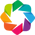

In [11]:
import holoviews as hv
hv.extension('bokeh')

In [12]:
def site_timeseries(data):
    """Timeseries plot showing the mean carbon flux at each DOY as well as the min and max"""
    
    tseries = hv.Overlay([
        (data.groupby(['DOY', 'year'])[y_variable]
             .mean().groupby('DOY').agg(['min', 'max'])
             .hvplot.area('DOY', 'min', 'max', alpha=0.2, fields={'min': y_variable})),
        data.groupby('DOY')[y_variable].mean().hvplot()])
    
    return tseries.options(width=450, height=400)

def site_count_plot(data):
    """Plot of the number of observations of each of the non-mandatory variables."""
    return data[soil_data_columns + ['site']].count().hvplot.bar(rot=90, width=300, height=400)

timeseries = site_timeseries(data)
count_plot = site_count_plot(data)
timeseries + count_plot

:Layout
   .Overlay.I :Overlay
      .Area.I                :Area   [DOY]   (NEE_CUT_USTAR50,max)
      .Curve.NEE_CUT_USTAR50 :Curve   [DOY]   (NEE_CUT_USTAR50)
   .Bars.A_0  :Bars   [index]   (0)

### Dashboard

Using the plots and functions defined above, we can make a [Panel](https://panel.holoviz.org) dashboard of sites where by clicking on a site, you get the timeseries and variable count for that particular site.

In [13]:
from holoviews.streams import Selection1D
import panel as pn

In [14]:
stream = Selection1D(source=all_points)
empty = timeseries.relabel('No selection') + count_plot.relabel('No selection')

def site_selection(index):
    if not index:
        return empty
    i = index[0]
    if i in QA[QA['quality']=='valid'].index:
        site = QA.iloc[i]['site']
        ts = site_timeseries(data[data['site'] == site]).relabel(site)
        ct = site_count_plot(data[data['site'] == site]).relabel(site)
        return ts + ct
    else:
        return empty

one_site = hv.DynamicMap(site_selection, streams=[stream])

pn.Column(pn.Row(all_points, hist), pn.Row(one_site))

Column
    [0] Row
        [0] HoloViews(Overlay, height=420, sizing_mode='fixed', width=500)
        [1] HoloViews(Bars, height=420, sizing_mode='fixed', width=500)
    [1] Row
        [0] HoloViews(DynamicMap)

## Merge data

Now that the data are loaded in we can merge the daily data with the metadata from before.

In order to use the categorical `igbp` field with machine-learning tools, we will create a one-hot encoding where each column corresponds to one of the `igbp` types, the rows correspond to observations and all the cells are filled with 0 or 1. This can be done use the method `pd.get_dummies`:

In [15]:
onehot_metadata = pd.get_dummies(metadata, columns=['igbp'])
onehot_metadata.sample(5)

site      lat       lon                       vegetation  igbp_BSV  \
153  AU-Wac -37.4259  145.1878  02 - Evergreen Broadleaf Forest     False   
79   US-NC1  35.8118  -76.7119             07 - Open shrublands     False   
94   US-Ro6  44.6946  -93.0578                   12 - Croplands     False   
191  CN-Dan  30.4978   91.0664                  10 - Grasslands     False   
247  IT-Noe  40.6062    8.1512           06 - Closed Shrublands     False   

     ...  igbp_SAV  igbp_SNO  igbp_WAT  igbp_WET  igbp_WSA  
153  ...     False     False     False     False     False  
79   ...     False     False     False     False     False  
94   ...     False     False     False     False     False  
191  ...     False     False     False     False     False  
247  ...     False     False     False     False     False  

[5 rows x 19 columns]

We'll do the same for season - keeping season as a column. 

In [16]:
data = pd.get_dummies(data, columns=['season']).assign(season=data['season'])

We'll merge the metadata with all our daily observations - creating a tidy dataframe. 

In [17]:
df = pd.merge(data, onehot_metadata, on='site')
df.sample(5)

P_ERA  TA_ERA   PA_ERA  SW_IN_ERA  LW_IN_ERA  ...  igbp_SAV  igbp_SNO  \
332827  0.000 -16.963   94.767    167.884    176.034  ...     False     False   
531039  0.000  -2.072   70.291    115.995    206.047  ...     False     False   
274784  1.481   6.537   99.335     76.616    321.704  ...     False     False   
444483  0.000   3.496  101.213     55.438    253.971  ...     False     False   
360081  5.574   8.255  101.618     30.687    359.471  ...     False     False   

       igbp_WAT igbp_WET  igbp_WSA  
332827    False    False     False  
531039    False    False     False  
274784    False    False     False  
444483    False    False     False  
360081    False    False     False  

[5 rows x 41 columns]

### Visualizing Soil Data Availability at Sites
Now that all of our observations are merged with the site metadata, we can take a look at which sites have soil data. Some sites have soil moisture and temperature data at one depths and others have the data at all 3 depths. We'll look at the distribution of availability across sites.

In [18]:
import geoviews.tile_sources as gts

In [19]:
partial_soil_data = df[df[soil_data_columns].notnull().any(axis=1)]
partial_soil_data_sites = metadata[metadata.site.isin(partial_soil_data.site.unique())]

In [20]:
full_soil_data = df[df[soil_data_columns].notnull().all(1)]
full_soil_data_sites = metadata[metadata.site.isin(full_soil_data.site.unique())]

In [21]:
args = dict(geo=True, hover_cols=['site', 'vegetation'], height=420, width=500)

partial = partial_soil_data_sites.hvplot.points('lon', 'lat', **args).relabel('partial soil data')
full    =    full_soil_data_sites.hvplot.points('lon', 'lat', **args).relabel('full soil data')

(partial * full * gts.OSM).options(legend_position='top') +  veg_count(partial_soil_data_sites) * veg_count(full_soil_data_sites)

:Layout
   .Overlay.I     :Overlay
      .Points.Partial_soil_data :Points   [lon,lat]   (site,vegetation)
      .Points.Full_soil_data    :Points   [lon,lat]   (site,vegetation)
      .WMTS.I                   :WMTS   [Longitude,Latitude]
   .Overlay.Count :Overlay
      .Bars.Count.I  :Bars   [vegetation]   (count)
      .Bars.Count.II :Bars   [vegetation]   (count)

Since there seems to be a strong geographic pattern in the availablity of soil moisture and soil temperature data, we won't use those columns in our model. 

In [22]:
df = df.drop(columns=soil_data_columns)

Now we will set data to only the rows where there are no null values:

In [23]:
df = df[df.notnull().all(1)].reset_index(drop=True)

In [24]:
df['site'] = df['site'].astype('category')

### Assigning roles to variables

Before we train a model to predict carbon flux globally we need to choose which variables will be included in the input to the model. For those we should only use variables that we expect to have some relationship with the variable that we are trying to predict. 

In [25]:
explanatory_cols = ['lat']
data_cols = ['P_ERA', 'TA_ERA', 'PA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'WS_ERA', 'VPD_ERA']
season_cols = [col for col in df.columns if col.startswith('season_')]
igbp_cols = [col for col in df.columns if col.startswith('igbp_')]

In [26]:
x = df[data_cols + igbp_cols + explanatory_cols + season_cols].values
y = df[y_variable].values

### Scaling the Data

In [27]:
from sklearn.preprocessing import StandardScaler

# transform data matrix so 0 mean, unit variance for each feature
X = StandardScaler().fit_transform(x)

Now we are ready to train a model to predict carbon flux globally. 

## Training and Testing

We'll shuffle the sites and select 10% of them to be used as a test set. The rest we will use for training. Note that you might get better results using leave-one-out, but since we have a large amount of data, classical validation will be much faster.

In [28]:
from sklearn.model_selection import GroupShuffleSplit

sep = GroupShuffleSplit(train_size=0.9, test_size=0.1)
train_idx, test_idx = next(sep.split(X, y, df.site.cat.codes.values))

In [29]:
train_sites = df.site.iloc[train_idx].unique()
test_sites = df.site.iloc[test_idx].unique()

train_site_metadata = metadata[metadata.site.isin(train_sites)]
test_site_metadata = metadata[metadata.site.isin(test_sites)]

Let's make a world map showing the sites that will be used as in training and those that will be used in testing:

In [30]:
train = train_site_metadata.hvplot.points('lon', 'lat', **args).relabel('training sites')
test  = test_site_metadata.hvplot.points( 'lon', 'lat', **args).relabel('testing sites') 

(train * test * gts.OSM).options(legend_position='top') +  veg_count(train_site_metadata) * veg_count(test_site_metadata)

:Layout
   .Overlay.I     :Overlay
      .Points.Training_sites :Points   [lon,lat]   (site,vegetation)
      .Points.Testing_sites  :Points   [lon,lat]   (site,vegetation)
      .WMTS.I                :WMTS   [Longitude,Latitude]
   .Overlay.Count :Overlay
      .Bars.Count.I  :Bars   [vegetation]   (count)
      .Bars.Count.II :Bars   [vegetation]   (count)

This distribution seems reasonably uniform and unbiased, though a different random sampling might have allowed testing for each continent and all vegetation types.

## Training the Regression Model

We'll construct a linear regression model using our randomly selected training sites and test sites.

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
model = LinearRegression()
model.fit(X[train_idx], y[train_idx]);

We'll create a little function to look at observed vs predicted values

In [33]:
from holoviews.operation.datashader import datashade

def result_plot(predicted, observed, title, corr=None, res=0.1):
    """Plot datashaded observed vs predicted"""
    
    corr = corr if corr is not None else np.corrcoef(predicted, observed)[0][1]
    title = f'{title} (correlation: {corr:.02f})'
    scatter = hv.Scatter((predicted, observed), 'predicted', 'observed')\
                .redim.range(predicted=(observed.min(), observed.max()))
    
    return datashade(scatter, y_sampling=res, x_sampling=res).relabel(title)

In [34]:
(result_plot(model.predict(X[train_idx]), y[train_idx], 'Training') + \
 result_plot(model.predict(X[test_idx ]), y[test_idx],  'Testing')).options('RGB', axiswise=True, width=500)

:Layout
   .DynamicMap.Training_left_parenthesis_correlation_colon_0_full_stop_45_right_parenthesis :DynamicMap   []
      :RGB   [predicted,observed]   (R,G,B,A)
   .DynamicMap.Testing_left_parenthesis_correlation_colon_0_full_stop_45_right_parenthesis  :DynamicMap   []
      :RGB   [predicted,observed]   (R,G,B,A)

### Prediction at test sites

We can see how well the prediction does at each of our testing sites by making another dashboard. 

In [35]:
results = []

for site in test_sites:
    site_test_idx = df[df.site == site].index
    y_hat_test = model.predict(X[site_test_idx])
    corr =  np.corrcoef(y_hat_test, y[site_test_idx])[0][1]
    
    results.append({'site': site,
                    'observed': y[site_test_idx], 
                    'predicted': y_hat_test, 
                    'corr': corr})

In [36]:
test_site_results = pd.merge(test_site_metadata, pd.DataFrame(results), 
                             on='site').set_index('site', drop=False)

Now we can set up another dashboard with just the test sites, where tapping on a given site produces a plot of the predicted vs. observed carbon flux.

First we'll set up a timeseries function.

In [37]:
def timeseries_observed_vs_predicted(site=None):
    """
    Make a timeseries plot showing the predicted/observed 
    mean carbon flux at each DOY as well as the min and max
    """
    if site:
        data = df[df.site == site].assign(predicted=test_site_results.loc[site, 'predicted'])
        corr = test_site_results.loc[site, 'corr']
        title = f'Site: {site}, correlation coefficient: {corr:.02f}'
    else:
        data = df.assign(predicted=np.nan)
        title = 'No Selection'

    spread = data.groupby(['DOY', 'year'])[y_variable].mean().groupby('DOY').agg(['min', 'max']) \
             .hvplot.area('DOY', 'min', 'max', alpha=0.2, fields={'min': 'observed'})
    observed  = data.groupby('DOY')[y_variable ].mean().hvplot().relabel('observed')
    predicted = data.groupby('DOY')['predicted'].mean().hvplot().relabel('predicted')
    
    return (spread * observed * predicted).options(width=800).relabel(title)

In [38]:
timeseries_observed_vs_predicted(test_sites[0])

:Overlay
   .Area.I          :Area   [DOY]   (observed,max)
   .Curve.Observed  :Curve   [DOY]   (NEE_CUT_USTAR50)
   .Curve.Predicted :Curve   [DOY]   (predicted)

Then we'll set up the points colored by correlation coefficient.

In [39]:
test_points = test_site_results.hvplot.points('lon', 'lat', geo=True, c='corr', legend=False,
                                              cmap='coolwarm_r', s=150, height=420, width=800, 
                                              hover_cols=['vegetation', 'site']).options(
                                              tools=['tap', 'hover'], line_color='black')

And put it together into a dashboard. This will look very similar to the one above.

In [40]:
test_stream = Selection1D(source=test_points)

def test_site_selection(index):
    site = None if not index else test_sites[index[0]]
    return timeseries_observed_vs_predicted(site)

one_test_site = hv.DynamicMap(test_site_selection, streams=[test_stream])
title = 'Test sites colored by correlation: tap on site to plot long-term-mean timeseries'

dash = pn.Column((test_points * gts.OSM).relabel(title), one_test_site)
dash.servable()

Column
    [0] HoloViews(Overlay, height=420, sizing_mode='fixed', width=800)
    [1] HoloViews(DynamicMap, height=300, sizing_mode='fixed', width=800)

## Optional: Seasonal Prediction

Clicking on some of the sites above suggests that prediction often works well for some months and not for others. Perhaps different variables are important for prediction, depending on the season? We might be able to achieve better results if we generate separate models for each season. First we'll set up a function that computes prediction stats for a given training index, test index, array of X, array of y and array of seasons.

In [41]:
seasons = ['summer', 'fall', 'spring', 'winter']

In [42]:
def prediction_stats(train_idx, test_idx, X, y, season):
    """
    Compute prediction stats for equal length arrays X, y, and season
    split into train_idx and test_idx
    """
    pred = {}

    for s in seasons:
        season_idx = np.where(season==s)
        season_train_idx = np.intersect1d(season_idx, train_idx, assume_unique=True)
        season_test_idx = np.intersect1d(season_idx, test_idx, assume_unique=True)
        
        model = LinearRegression()
        model.fit(X[season_train_idx], y[season_train_idx])
        
        y_hat = model.predict(X[season_test_idx])
        y_test = y[season_test_idx]
        pred[s] = {'predicted': y_hat,
                   'observed': y_test,
                   'corrcoef': np.corrcoef(y_hat, y_test)[0][1],
                   'test_index': test_idx}
    return pred

### Setup Dask
With dask, we can distribute tasks over cores and do parallel computation. For more information see https://dask.org/

In [43]:
from distributed import Client

client = Client()
client

<Client: 'tcp://127.0.0.1:38637' processes=4 threads=4, memory=15.61 GiB>

Now we'll scatter our data using `dask` and make a bunch of different splits. For each split we'll compute the predicton stats for each season.

In [44]:
futures = []
sep = GroupShuffleSplit(n_splits=50, train_size=0.9, test_size=0.1)

X_future = client.scatter(X)
y_future = client.scatter(y)
season_future = client.scatter(df['season'].values)

for train_index, test_index in sep.split(X, y, df.site.cat.codes.values):
    futures += [client.submit(prediction_stats, train_index, test_index,
                              X_future, y_future, season_future)]

Now that we have our computations set up in dask, we can gather the results:

In [45]:
results = client.gather(futures)

And consolidate the results for each season.

In [46]:
output = {
    s: {
        'predicted': np.concatenate([i[s]['predicted'] for i in results]),
        'observed': np.concatenate([i[s]['observed'] for i in results]),
        'test_index': np.concatenate([i[s]['test_index'] for i in results]),
        'corrcoef': np.array([i[s]['corrcoef'] for i in results])
    } for s in seasons}

In [47]:
hv.Layout([
    result_plot(output[s]['predicted'], output[s]['observed'], s, output[s]['corrcoef'].mean())
    for s in seasons]).cols(2).options('RGB', axiswise=True, width=400)

:Layout
   .DynamicMap.Summer_left_parenthesis_correlation_colon_0_full_stop_41_right_parenthesis :DynamicMap   []
      :RGB   [predicted,observed]   (R,G,B,A)
   .DynamicMap.Fall_left_parenthesis_correlation_colon_0_full_stop_34_right_parenthesis   :DynamicMap   []
      :RGB   [predicted,observed]   (R,G,B,A)
   .DynamicMap.Spring_left_parenthesis_correlation_colon_0_full_stop_24_right_parenthesis :DynamicMap   []
      :RGB   [predicted,observed]   (R,G,B,A)
   .DynamicMap.Winter_left_parenthesis_correlation_colon_0_full_stop_26_right_parenthesis :DynamicMap   []
      :RGB   [predicted,observed]   (R,G,B,A)

In [48]:
def helper(s):
    corr = output[s]['corrcoef']
    return pd.DataFrame([corr, [s] * len(corr)], index=['corr', 'season']).T

corr = pd.concat(map(helper, seasons)).reset_index(drop=True)

In [49]:
corr.hvplot.hist(y='corr', groupby='season', bins=np.arange(0, .9, .05).tolist(), dynamic=False, width=500)

:HoloMap   [season]
   :Histogram   [corr]   (Count)

## Suggested Next Steps

 - Can we predict certain vegetations better than others?
 - Calculate fraction of explained variance.
 - Replace each FluxNet input variable with a remotely sensed (satellite imaged) quantity to predict carbon flux globally